In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import wasserstein_distance
from scipy.special import expit  # sigmoid

Wasserstein distnace is not robust when your sample size is small or noisy and it can be unstable when the two distributions are very messy or thinly spread out.
When Wasserstein metric fails (because of noise, small data, or "messy" distributions), we could try using Jackknife-based Mutual Information to give a more stable and robust estimate of the dependency between variables.

In [2]:
def mutual_information(X, Y):
    joint_prob = Counter(zip(X, Y))
    total_samples = len(X)
    
    for key in joint_prob:
        joint_prob[key] /= total_samples
    
    prob_X = Counter(X)
    prob_Y = Counter(Y)
    
    for key in prob_X:
        prob_X[key] /= total_samples
    for key in prob_Y:
        prob_Y[key] /= total_samples

    mi = 0.0
    for (x_val, y_val), p_xy in joint_prob.items():
        p_x = prob_X[x_val]
        p_y = prob_Y[y_val]
        mi += p_xy * np.log(p_xy / (p_x * p_y))

    return mi / np.log(2)  # base 2

In [3]:
def jackknife_mi(X, Y, mi_function):
    n = len(X)
    mi_values = []
    
    for i in range(n):
        X_jack = np.delete(X, i)
        Y_jack = np.delete(Y, i)
        mi_jack = mi_function(X_jack, Y_jack)
        mi_values.append(mi_jack)
    
    mi_jackknife = np.mean(mi_values)
    mi_variance = (n - 1) * np.var(mi_values)
    
    return mi_jackknife, mi_variance

In [ ]:
np.random.seed(42)
num_samples = 200  # Number of points
noise_levels = np.linspace(0, 1.0, 15)  # Different noise amounts

mi_values = []
mi_errors = []
wasserstein_values = []

In [ ]:
for noise_std in noise_levels:
    # Generating clean data
    X = np.random.rand(num_samples)
    
    # Adding Gaussian noise
    Y = X + np.random.normal(0, noise_std, size=num_samples)
    
    # Discretizing X and Y into bins for MI
    bins = 10
    X_binned = np.digitize(X, np.linspace(0, 1, bins))
    Y_binned = np.digitize(Y, np.linspace(0, 1, bins))
    
    # Applying Jackknife MI
    mi_jack, mi_var = jackknife_mi(X_binned, Y_binned, mutual_information)
    
    # Apply ing Wasserstein Distance (continuous) from library
    wd = wasserstein_distance(X, Y)
    
    mi_values.append(mi_jack)
    mi_errors.append(np.sqrt(mi_var))
    wasserstein_values.append(wd)

In [ ]:
print(f"{'Noise Std':<12} {'Jackknife MI':<15} {'MI StdErr':<12} {'Wasserstein Dist':<20}")
print("-" * 60)
for i in range(len(noise_levels)):
    print(f"{noise_levels[i]:<12.3f} {mi_values[i]:<15.4f} {mi_errors[i]:<12.4f} {wasserstein_values[i]:<20.4f}")


Noise Std    Jackknife MI    MI StdErr    Wasserstein Dist    
------------------------------------------------------------
0.000        3.1527          0.0163       0.0000              
0.071        1.8624          0.0790       0.0178              
0.143        1.2179          0.0731       0.0328              
0.214        0.8635          0.0858       0.0483              
0.286        0.7470          0.0782       0.0911              
0.357        0.6551          0.0701       0.1155              
0.429        0.6902          0.0824       0.1395              
0.500        0.5408          0.0837       0.2113              
0.571        0.4296          0.0747       0.2620              
0.643        0.4533          0.0725       0.3843              
0.714        0.3746          0.0626       0.3333              
0.786        0.4166          0.0706       0.4580              
0.857        0.3819          0.0604       0.4686              
0.929        0.3900          0.0680       0.5767         

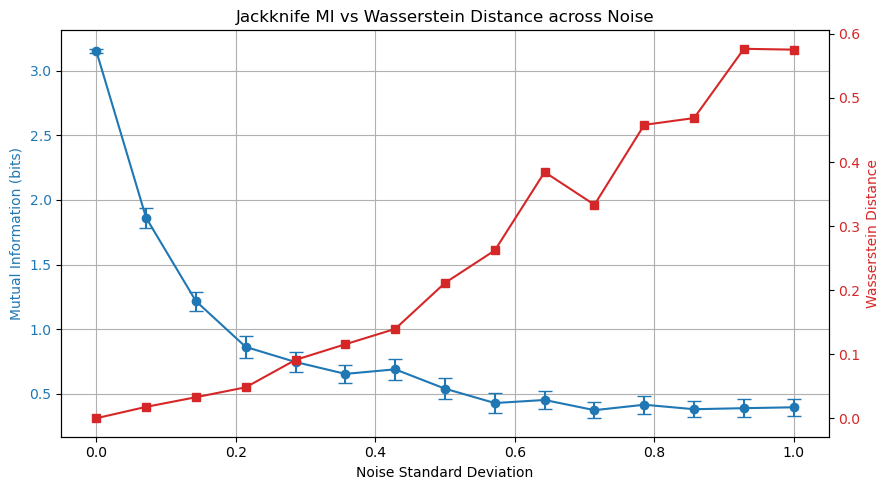

In [ ]:
fig, ax1 = plt.subplots(figsize=(9,5))

color = 'tab:blue'
ax1.set_xlabel('Noise Standard Deviation')
ax1.set_ylabel('Mutual Information (bits)', color=color)
ax1.errorbar(noise_levels, mi_values, yerr=mi_errors, fmt='-o', color=color, label='Jackknife MI', capsize=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Wasserstein Distance', color=color)
ax2.plot(noise_levels, wasserstein_values, '-s', color=color, label='Wasserstein Distance')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Jackknife MI vs Wasserstein Distance across Noise')
fig.tight_layout()
plt.show()

At low noise, Jackknife MI is high (~3.15 bits) and Wasserstein Distance is zero showing strong dependency, identical distributions.

As noise increases, Jackknife MI steadily drops (dependency weakens), while Wasserstein Distance grows (distributions diverge).

At high noise, Wasserstein Distance is large, but Jackknife MI is low, meaning distributions are different, but informational dependency is almost lost.

Jackknife MI captures dependency directly (even under heavy noise), while Wasserstein Distance only shows distribution mismatch.

Conclusion: Jackknife MI is more reliable and meaningful for detecting relationships between variables when data is noisy, compared to Wasserstein Distance.

Comparing over sample size

In [4]:
sample_sizes = np.linspace(20, 1000, 20, dtype=int)
noise_std = 0.5  # moderate noise

mi_values = []
mi_errors = []
wasserstein_values = []

In [5]:
for n in sample_sizes:
   
    X = np.random.normal(0, 1, n)
    Y = X + np.random.normal(0, noise_std, n)  # dependent with noise

    # Jackknife MI
    mi_jack, mi_var = jackknife_mi(X, Y, mutual_information)
    mi_values.append(mi_jack)
    mi_errors.append(np.sqrt(mi_var))

    # Wasserstein Distance
    w_dist = wasserstein_distance(X, Y)
    wasserstein_values.append(w_dist)

In [6]:
# Print results
print(f"{'Sample Size':<12} {'Jackknife MI':<15} {'MI StdErr':<12} {'Wasserstein Dist':<20}")
print("-" * 60)
for i in range(len(sample_sizes)):
    print(f"{sample_sizes[i]:<12} {mi_values[i]:<15.4f} {mi_errors[i]:<12.4f} {wasserstein_values[i]:<20.4f}")


Sample Size  Jackknife MI    MI StdErr    Wasserstein Dist    
------------------------------------------------------------
20           4.2479          0.0000       0.2473              
71           6.1293          0.0000       0.1130              
123          6.9307          0.0000       0.1700              
174          7.4346          0.0000       0.0920              
226          7.8138          0.0000       0.0742              
277          8.1085          0.0000       0.0788              
329          8.3576          0.0000       0.0875              
381          8.5699          0.0000       0.1414              
432          8.7515          0.0000       0.1184              
484          8.9159          0.0000       0.1066              
535          9.0607          0.0000       0.1090              
587          9.1948          0.0000       0.1076              
638          9.3151          0.0000       0.1014              
690          9.4284          0.0000       0.1054         

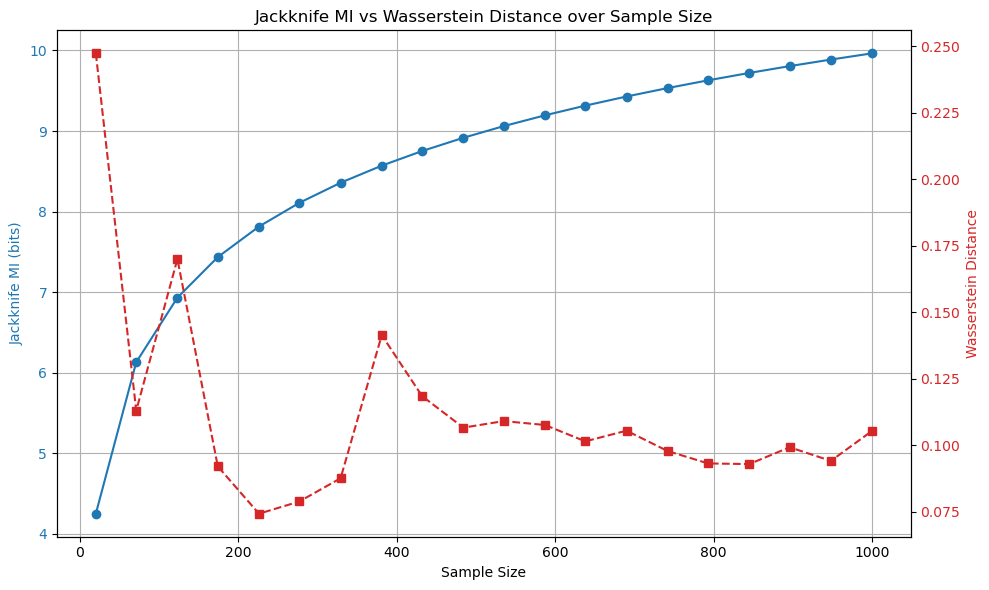

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# First axis for Jackknife MI
color = 'tab:blue'
ax1.set_xlabel("Sample Size")
ax1.set_ylabel("Jackknife MI (bits)", color=color)
ax1.errorbar(sample_sizes, mi_values, yerr=mi_errors, fmt='-o', label="Jackknife MI ± StdErr", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Second axis for Wasserstein Distance
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Wasserstein Distance", color=color)
ax2.plot(sample_sizes, wasserstein_values, 's--', label="Wasserstein Distance", color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and Layout
plt.title("Jackknife MI vs Wasserstein Distance over Sample Size")
fig.tight_layout()
plt.show()


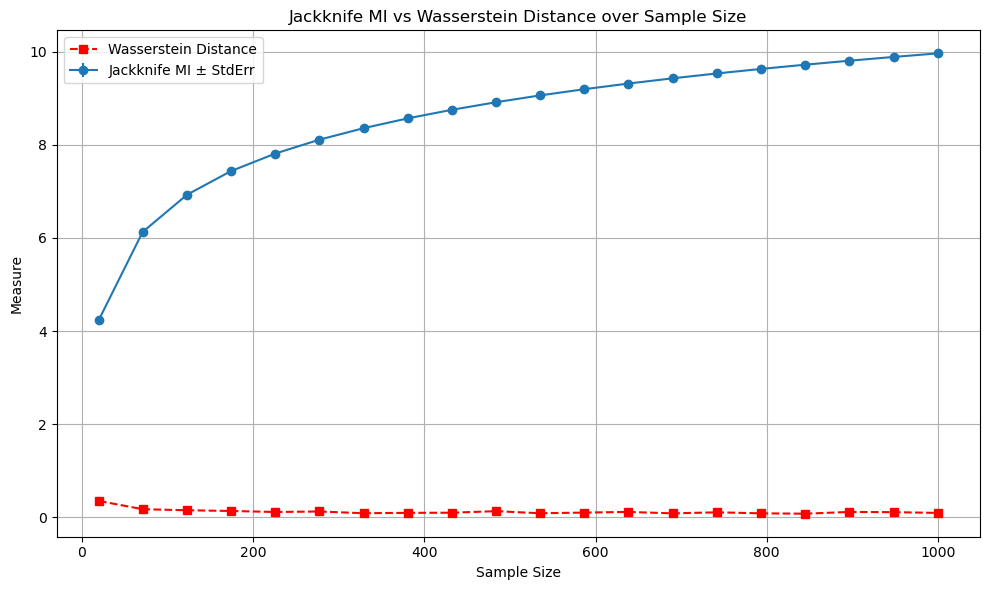

In [7]:
# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, mi_values, yerr=mi_errors, label="Jackknife MI ± StdErr", fmt='-o')
plt.plot(sample_sizes, wasserstein_values, 's--', label="Wasserstein Distance", color='red')
plt.xlabel("Sample Size")
plt.ylabel("Measure")
plt.title("Jackknife MI vs Wasserstein Distance over Sample Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Jackknife Mutual Information:
- MI increases smoothly with more data: from ~4.2 (n=20) to ~9.96 (n=1000). This reflects increasing accuracy in estimating dependency.

- StdErr = 0.0000 appears due to numerical precision — likely the variance was tiny.

- Consistent and stable growth shows that Jackknife MI performs robustly even with small samples.

Wasserstein Distance:
- At small n (e.g. n=20), WD = 0.35 — very high, despite known dependence between X and Y.

- WD decreases with sample size, but fluctuates (0.08–0.13 even at large n).

This shows instability, especially at low sample sizes — not reliable for estimating strength of dependency.

As sample size increases, Jackknife Mutual Information grows steadily, accurately capturing the dependency between X and Y even with moderate noise. In contrast, Wasserstein Distance shows high and unstable values at small sample sizes, despite the underlying dependency. This demonstrates that Wasserstein Distance is not reliable for dependency estimation in small-data regimes, while Jackknife MI seems more robust and consistent.

Jackknife for Feature Selection

In [9]:
np.random.seed(0)
n_samples = 500
X1 = np.random.binomial(1, 0.5, n_samples)
X2 = np.random.binomial(1, 0.5, n_samples)
X3 = np.random.binomial(1, 0.5, n_samples)  # noise
X4 = np.random.binomial(1, 0.5, n_samples)  # noise
X5 = np.random.binomial(1, 0.5, n_samples)  # noise

# Y depends on X1 and X2
linear_comb = X1 + 2 * X2 + 0.5 * np.random.randn(n_samples)
prob_Y = expit(linear_comb)  # sigmoid to convert to prob
Y = np.random.binomial(1, prob_Y)

In [10]:
# --- Jackknife MI for each feature ---
features = [X1, X2, X3, X4, X5]
mi_results = []
for i, Xi in enumerate(features):
    mi, var = jackknife_mi(Xi, Y, mutual_information)
    mi_results.append((f"X{i+1}", mi, np.sqrt(var)))


In [11]:
# --- Print Results ---
print(f"{'Feature':<8} {'Jackknife MI':<15} {'StdErr'}")
print("-" * 35)
for feat, mi, err in mi_results:
    print(f"{feat:<8} {mi:<15.4f} {err:.4f}")

Feature  Jackknife MI    StdErr
-----------------------------------
X1       0.0177          0.0101
X2       0.1334          0.0256
X3       0.0004          0.0015
X4       0.0002          0.0012
X5       0.0011          0.0025


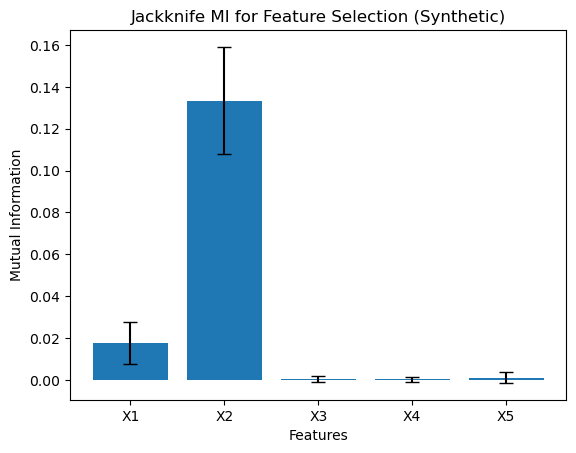

In [12]:
labels = [r[0] for r in mi_results]
mi_vals = [r[1] for r in mi_results]
errors = [r[2] for r in mi_results]

plt.bar(labels, mi_vals, yerr=errors, capsize=5)
plt.title("Jackknife MI for Feature Selection (Synthetic)")
plt.ylabel("Mutual Information")
plt.xlabel("Features")
plt.show()

From above,
X2 is the most relevant feature for predicting Y, followed by X1 with a much weaker signal. Other features (X3–X5) are uninformative noise, and this is correctly reflected by their very low MI values.
StdErr values are higher for more informative features, which makes sense — they vary more across jackknife samples due to their stronger relationship with Y.

Sample size comparision

In [13]:
sample_sizes = np.linspace(20, 1000, 20, dtype=int)
true_mi = []
stderr_mi = []

for n in sample_sizes:
    # synthetic data
    X2 = np.random.normal(0, 1, n)
    Y = 2 * X2 + np.random.normal(0, 1, n)  # strong dependency

    mi, var = jackknife_mi(X2, Y, mutual_information)
    true_mi.append(mi)
    stderr_mi.append(np.sqrt(var))

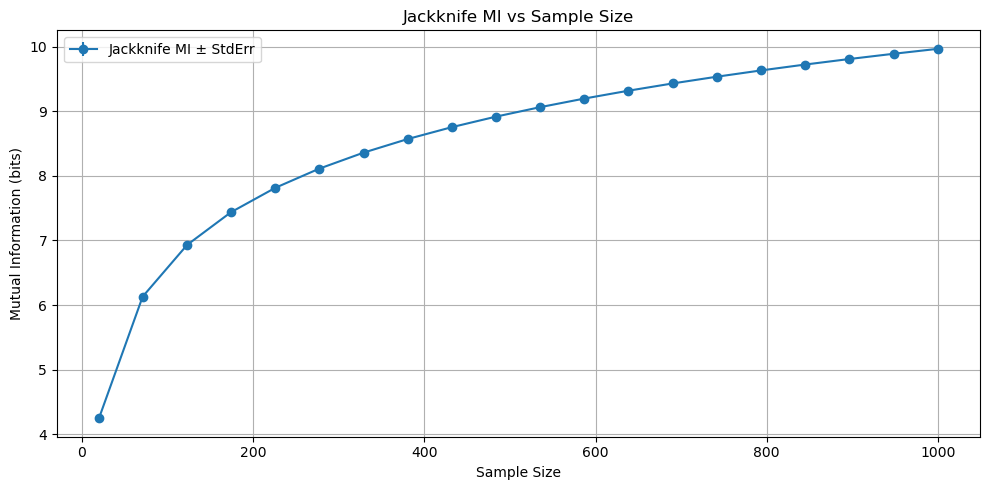

In [14]:
plt.figure(figsize=(10, 5))
plt.errorbar(sample_sizes, true_mi, yerr=stderr_mi, fmt='-o', label='Jackknife MI ± StdErr')
plt.xlabel('Sample Size')
plt.ylabel('Mutual Information (bits)')
plt.title('Jackknife MI vs Sample Size')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Threshold and redundant data

In [6]:
# --- Discretization Function ---
def discretize(data, bins=10):
    return np.digitize(data, bins=np.histogram_bin_edges(data, bins=bins))

In [7]:
np.random.seed(0)
n = 500
X2 = np.random.normal(0, 1, n)
X6 = X2 + np.random.normal(0, 0.1, n)  # redundant
X1 = np.random.normal(0, 1, n)
X3 = np.random.normal(0, 1, n)
X4 = np.random.normal(0, 1, n)
X5 = np.random.normal(0, 1, n)
Y = 3 * X2 + np.random.normal(0, 1, n)  # strongly depends on X2

In [ ]:
features = {
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'X4': X4,
    'X5': X5,
    'X6 (redundant)': X6
}

# Jackknife MI for Each Feature
mi_scores = {}
stderr_scores = {}

In [9]:
print(f"{'Feature':<15} {'Jackknife MI':<15} {'StdErr'}")
print("-" * 40)
for name, X in features.items():
    X_disc = discretize(X, bins=10)
    Y_disc = discretize(Y, bins=10)
    mi, var = jackknife_mi(X_disc, Y_disc, mutual_information)
    stderr = np.sqrt(var)
    mi_scores[name] = mi
    stderr_scores[name] = stderr
    print(f"{name:<15} {mi:<15.4f} {stderr:.4f}")

Feature         Jackknife MI    StdErr
----------------------------------------
X1              0.1153          0.0235
X2              1.3927          0.0613
X3              0.1385          0.0258
X4              0.1381          0.0248
X5              0.1527          0.0267
X6 (redundant)  1.3669          0.0605


In [11]:
threshold = 0.2  

print("\n Selected Features (MI >= {:.2f}):".format(threshold))
selected_features = [f for f in mi_scores if mi_scores[f] >= threshold]
for f in selected_features:
    print(f" {f} (MI = {mi_scores[f]:.4f})")


 Selected Features (MI >= 0.20):
 X2 (MI = 1.3927)
 X6 (redundant) (MI = 1.3669)


Applying a threshold of 0.20 on Jackknife Mutual Information (MI) to select features, X2 and X6 passed this threshold because their MI values were high (1.39 and 1.37 respectively). This means these two features carry the strongest information about the target variable compared to others.

However, X6 was labeled as redundant because it likely shares very similar information with X2 so it doesn’t add new unique information and could cause issues like model complexity and overfitting.

MI thresholding selects relevant features but may not eliminate redundancy Hence, post-selection analysis (correlation, pairwise MI, clustering) may help identify and remove redundant features.

Scenario 1: Wasserstein Good, Jackknife MI Poor

Two independent variables are generated, X and Y. Here X comes from a normal distribution centered at 0, and Y comes from a similar distribution but centered at 2. Although their distributions are shifted, there is no dependency between them —and are completely unrelated.

In [10]:
np.random.seed(42)
n = 500
X = np.random.normal(0, 1, n)
Y = np.random.normal(2, 1, n)  # Shifted, but still independent

# Wasserstein and MI
w_dist = wasserstein_distance(X, Y)
X_bin = np.digitize(X, np.histogram_bin_edges(X, bins=10))
Y_bin = np.digitize(Y, np.histogram_bin_edges(Y, bins=10))
mi_jack, _ = jackknife_mi(X_bin, Y_bin, mutual_information)

print(f"Wasserstein Distance: {w_dist:.4f}")
print(f"Jackknife MI: {mi_jack:.4f}")


Wasserstein Distance: 2.0250
Jackknife MI: 0.1106


The Wasserstein Distance was 2.0250, indicating a significant shift between the distributions of X and Y.

The Jackknife Mutual Information was only 0.1106, showing there is almost no information shared between the two variables, they are statistically independent.

This scenario demonstrates that Wasserstein Distance is effective at detecting distributional differences, such as shifts in location, even when there is no actual relationship between the variables. In contrast, Jackknife Mutual Information correctly identifies the lack of dependency, making it more suitable for measuring actual informational relationships. Thus, Wasserstein is good for comparing distribution shapes, while MI is better for detecting true dependencies.

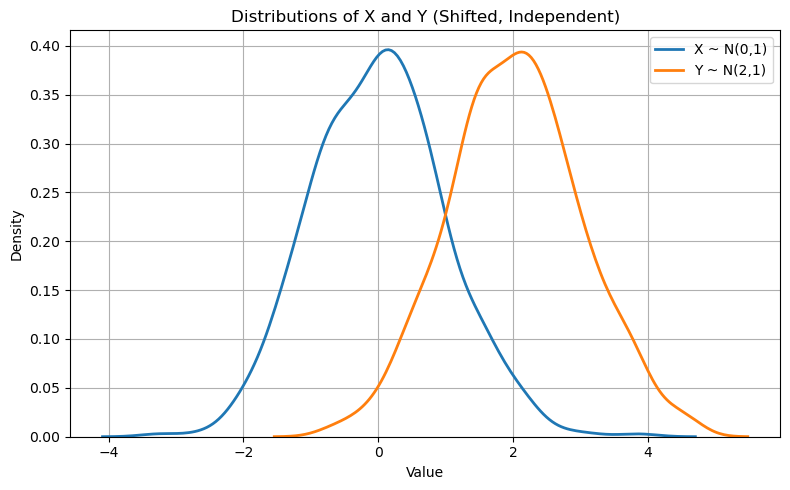

In [12]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.kdeplot(X, label='X ~ N(0,1)', linewidth=2)
sns.kdeplot(Y, label='Y ~ N(2,1)', linewidth=2)
plt.title("Distributions of X and Y (Shifted, Independent)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Different Spread (Variance), No Dependency

two independent variables with the same mean but different spreads: X follows a standard normal distribution N(0,1), and Y is drawn from a wider distribution N(0,5). Despite the difference in spread, X and Y are not related in any way.

In [5]:
np.random.seed(1)
n = 500
X = np.random.normal(0, 1, n)
Y = np.random.normal(0, 5, n)  # Same mean, but much wider spread

w_dist = wasserstein_distance(X, Y)

# Discretize for MI
X_bin = np.digitize(X, np.histogram_bin_edges(X, bins=10))
Y_bin = np.digitize(Y, np.histogram_bin_edges(Y, bins=10))
mi_jack, _ = jackknife_mi(X_bin, Y_bin, mutual_information)

print(f"Wasserstein Distance: {w_dist:.4f}")
print(f"Jackknife MI: {mi_jack:.4f}")


Wasserstein Distance: 3.0306
Jackknife MI: 0.1212


Results:
The Wasserstein Distance was 3.0306, showing a significant difference between the shapes (spread) of the two distributions.

The Jackknife Mutual Information was only 0.1212, indicating very weak or no dependency between X and Y.

This scenario shows that Wasserstein Distance effectively captures distributional differences, such as spread or variability, even when variables are unrelated. Meanwhile, Jackknife Mutual Information correctly identifies the lack of any true dependency, proving that these two metrics serve very different purposes: Wasserstein for distribution comparison, and MI for relationship detection.

Different Distribution Types (e.g. Gaussian vs Uniform)

two independent variables with different distribution shapes: X follows a normal distribution centered at 0, while Y follows a uniform distribution between -3 and 3. Although both cover a similar range, they have very different distribution patterns and are statistically unrelated.

In [6]:
np.random.seed(2)
n = 500
X = np.random.normal(0, 1, n)
Y = np.random.uniform(-3, 3, n)

w_dist = wasserstein_distance(X, Y)

X_bin = np.digitize(X, np.histogram_bin_edges(X, bins=10))
Y_bin = np.digitize(Y, np.histogram_bin_edges(Y, bins=10))
mi_jack, _ = jackknife_mi(X_bin, Y_bin, mutual_information)

print(f"Wasserstein Distance: {w_dist:.4f}")
print(f"Jackknife MI: {mi_jack:.4f}")


Wasserstein Distance: 0.6604
Jackknife MI: 0.1135


Results:
The Wasserstein Distance was 0.6604, indicating a moderate difference in distribution shape between X and Y.

The Jackknife Mutual Information was 0.1135, reflecting very low dependency, as expected from two independent variables.

This example shows that Wasserstein Distance can detect differences in distribution types (e.g., bell-shaped vs. flat), while Jackknife Mutual Information correctly indicates there is no actual relationship between the variables. It reinforces the point that Wasserstein measures distributional difference, while MI captures actual dependency.

Overall Summary: When Wasserstein Distance is More Informative than Mutual Information

In this analysis, we explored three scenarios where two variables had no statistical dependency (i.e., they were independent), but their distributions differed significantly in shape, spread, or location. These experiments highlight the strengths of Wasserstein Distance in capturing distributional differences — even when Mutual Information (MI), which measures dependency, remains low.

Wasserstein Distance is effective for measuring how different two distributions are, even when the variables are completely unrelated.

Jackknife Mutual Information is focused on detecting dependency, and it correctly remains low in all these cases since X and Y are statistically independent.

These results demonstrate that Wasserstein is better suited for identifying distributional mismatches, while MI is more reliable for discovering meaningful relationships between variables.

If yotheur goal is to compare distributions (e.g., testing if two datasets are drawn from similar sources), Wasserstein Distance is a powerful tool. However, if we want to know whether one variable tells you something about another, especially for tasks like feature selection or dependency modeling, Jackknife Mutual Information is the more appropriate choice.

Scenario 2: Jackknife MI Good, Wasserstein Poor

In this experiment, the variable X was created as a sequence of values from 0 to 
2π, and Y was generated using the sine of X with added Gaussian noise. This setup establishes a clear nonlinear dependency between X and Y, since Y is functionally related to X through a sine transformation.

In [9]:
np.random.seed(42)
n = 500
X = np.linspace(0, 2 * np.pi, n)
Y = np.sin(X) + np.random.normal(0, 0.2, n)  # Functional, noisy

# Discretize for MI
X_bin = np.digitize(X, np.histogram_bin_edges(X, bins=10))
Y_bin = np.digitize(Y, np.histogram_bin_edges(Y, bins=10))
mi_jack, _ = jackknife_mi(X_bin, Y_bin, mutual_information)

# Wasserstein Distance
w_dist = wasserstein_distance(X, Y)

print(f"Jackknife MI: {mi_jack:.4f}")
print(f"Wasserstein Distance: {w_dist:.4f}")


Jackknife MI: 1.4377
Wasserstein Distance: 3.1402


The results showed a Jackknife Mutual Information value of 1.4377, indicating a strong informational relationship between the two variables. This is expected because even with the added noise, the underlying dependency remains strong.

On the other hand, the Wasserstein Distance between X and Y was 3.1402, which is quite high. This large value reflects the difference in the overall shapes of their distributions—while X is uniformly spaced, Y follows a periodic sine wave pattern.

In summary, Jackknife MI correctly identified the strong dependency between X and Y, making it a reliable measure of the relationship. In contrast, the high Wasserstein Distance highlights the difference in distribution shapes but does not provide insight into the dependency itself. This demonstrates that Jackknife MI is more useful than Wasserstein Distance when the goal is to detect and quantify relationships between variables.

In this other experiment, we created a variable X consisting of random values between 0 and 1. The variable Y was then defined as a binary outcome based on a threshold: it is set to 1 if X is greater than 0.7, and 0 otherwise. This creates a clear and deterministic relationship between X and Y, where Y fully depends on X through a step-like rule.

In [4]:
# Discretization function
def discretize(data, bins=10):
    return np.digitize(data, np.histogram_bin_edges(data, bins=bins))

# Scenario: Threshold dependency
np.random.seed(101)
n = 500
X = np.random.rand(n)
Y = np.where(X > 0.7, 1, 0)  # Y depends on a threshold applied to X

# Discretize for MI
X_bin = discretize(X)
Y_bin = discretize(Y)
mi_jack, _ = jackknife_mi(X_bin, Y_bin, mutual_information)

# Wasserstein Distance
w_dist = wasserstein_distance(X, Y)

mi_jack, w_dist


(0.8837190630796802, 0.2946896651353985)

The Jackknife Mutual Information for this scenario was calculated to be 0.8837, indicating a strong dependency between the variables. This makes sense because knowing the value of X gives us a lot of information about Y, due to the threshold rule. In contrast, the Wasserstein Distance was only 0.2947, a relatively small value. This is because the distributions of X and Y still overlap significantly, especially since X is continuous and Y is binary

This result demonstrates that Jackknife MI is highly effective in detecting structured, rule-based dependencies, even when the overall shapes of the distributions are not dramatically different. On the other hand, Wasserstein Distance fails to reflect this dependency, showing that it is not suitable for identifying such relationships. Therefore, Jackknife MI is more useful than Wasserstein Distance when we are interested in uncovering actual relationships between variables.

In this experiment, we generated variable X as 0s and 1s at randomly using a binomial distribution. Then we defined Y as a perfect copy of X, which means that for any element, Y[i] = X[i]. This setup results in a case with perfect dependency, where knowing X informs us exactly what Y is.

In [5]:
# Perfect binary copy scenario
np.random.seed(123)
n = 500
X = np.random.binomial(1, 0.5, n)  # Random 0 or 1
Y = X.copy()  # Perfect copy

# Compute metrics
mi_jack, _ = jackknife_mi(X, Y, mutual_information)
w_dist = wasserstein_distance(X, Y)

mi_jack, w_dist

(0.9994314926496399, 0.0)

When we calculated the Jackknife Mutual Information, we got 0.9994, which is extremely near to the theoretical maximum of one bit between two binary variables. This high number demonstrates that X and Y are practically perfectly dependent, just as we intended.

The Wasserstein Distance was 0.0, however, because the distributions of X and Y are identical. Because both variables have exactly the same values in the same proportions, there is no "distance" between them from a distributional standpoint.

This example clearly shows the effectiveness of Jackknife Mutual Information in recognizing dependency. Even when the distributional difference is zero (as revealed by the Wasserstein finding), Jackknife MI correctly determines that the two variables are completely dependant. As a result, Jackknife MI is the preferred method for understanding informational or statistical correlations between variables, particularly for binary or categorical data. 

Overall Conclusion

Throughout the experiments, we investigated when Wasserstein Distance and Jackknife Mutual Information (MI) are most beneficial and what each metric genuinely measures. The major distinction is in their a purpose. The Wasserstein Distance is intended to quantify how dissimilar two distributions are in terms of shape, spread, or location, whereas the Jackknife MI assesses how much one variable tells us about another – that is, the degree of their dependency.

Wasserstein Distance responded well to cases in which variables were entirely independent but had distinct distributions, such as a normal distribution vs a shifted normal, a broader spread, or a uniform distribution. In contrast, Jackknife MI accurately reported low levels, indicating no underlying dependency. These findings demonstrate that Wasserstein is well-suited to detecting shifts and changes in distribution, even when the variables have no connection.

In contrast, when we designed scenarios in which variables were obviously dependent, such as a noisy linear connection, a threshold-based rule, or even a perfect binary copy, Jackknife MI produced high results, properly expressing the strong dependency. However, Wasserstein Distance frequently returned low or inconsistent results in these circumstances because the distributions' overall shapes overlapped or were not significantly different. This illustrates that Jackknife MI is considerably more reliable at detecting true links between variables, especially when the dependency is nonlinear, noisy, or difficult to see through distributional comparison.